<a href="https://colab.research.google.com/github/EstebanFTellezR/Modelaci-n-y-aja/blob/main/Regresiones_con_A%CC%81rboles_de_Decisio%CC%81n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresiones con Árboles de Decisión

Vamos a crear un modelo de regresión cuyo objetivo será predecir el Happiness Score con base en los datos del 2015.

Comenzamos limpiando los datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsr
from scipy.stats import shapiro, spearmanr
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score, explained_variance_score)
from sklearn.preprocessing import PowerTransformer

pd.set_option('display.max_columns', None)
sns.set_palette("husl")

data = pd.read_csv(r"C:\Users\Admon\Desktop\2015.csv", delimiter=';')

numeric_cols = ['Happiness Score', 'Standard Error', 'Economy (GDP per Capita)',
                'Family', 'Health (Life Expectancy)', 'Freedom',
                'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual']
for col in numeric_cols:
    data[col] = data[col].str.replace(',', '.').astype(float)

print("Valores faltantes por columna:")
print(data.isnull().sum())

data_clean = data.drop(['Country', 'Happiness Rank', 'Standard Error', 'Dystopia Residual'], axis=1)

print("\nInformación del dataset limpio:")
print(data_clean.info())

Valores faltantes por columna:
Country                          0
Region                           0
Happiness Rank                   0
Happiness Score                  0
Standard Error                   0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

Información del dataset limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Region                         158 non-null    object 
 1   Happiness Score                158 non-null    float64
 2   Economy (GDP per Capita)       158 non-null    float64
 3   Family                         158 non-null    float64
 4   Health (Life Expectancy)       158

Analizamos la distribución de las variables para determinar el mejor coeficiente para calcular la correlación entre las variables.
Por otro lado, para crear el modelo cuyo objetivo sea predecir el Happiness Score; tomaremos como base aquellas variables que tengan una correlación mayor a 0.3 con respecto a la variable objetivo.


Análisis de normalidad (Shapiro-Wilk):
Happiness Score                Shapiro p-value: 0.0188 - Distribución NO normal
Economy (GDP per Capita)       Shapiro p-value: 0.0005 - Distribución NO normal
Family                         Shapiro p-value: 0.0000 - Distribución NO normal
Health (Life Expectancy)       Shapiro p-value: 0.0000 - Distribución NO normal
Freedom                        Shapiro p-value: 0.0019 - Distribución NO normal
Trust (Government Corruption)  Shapiro p-value: 0.0000 - Distribución NO normal
Generosity                     Shapiro p-value: 0.0000 - Distribución NO normal

Usando correlación de SPEARMAN por distribución no normal


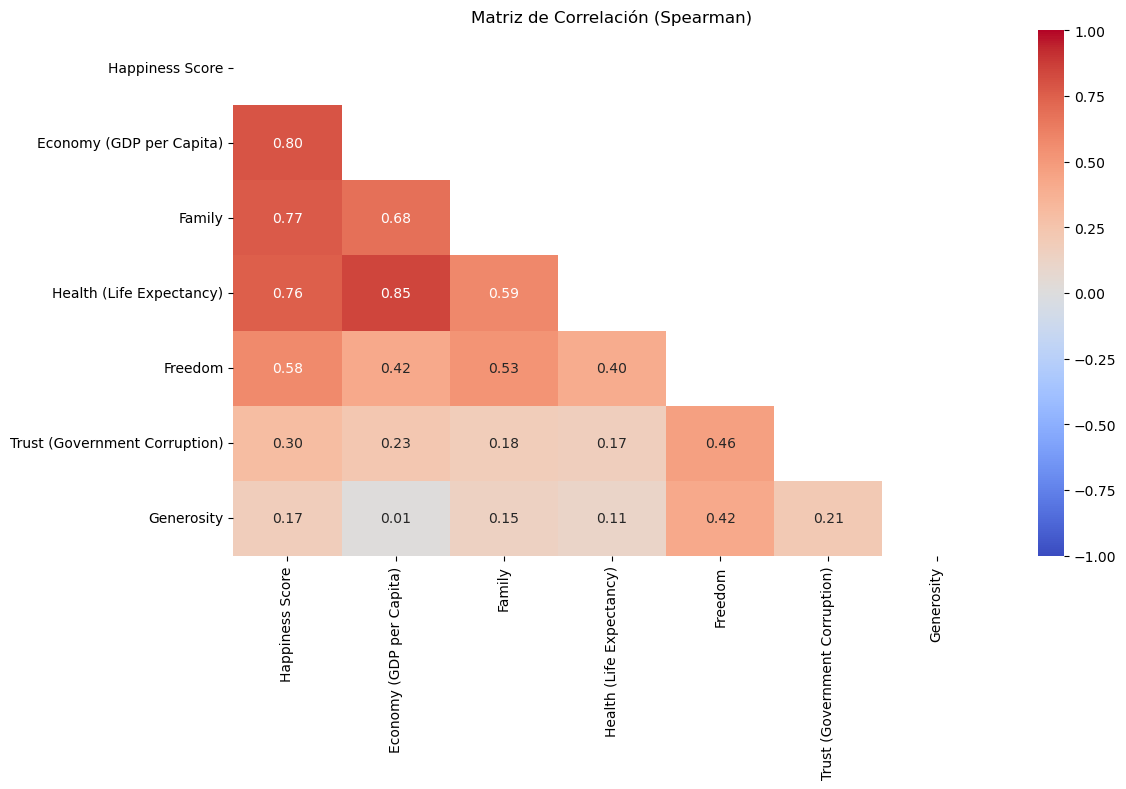


Características seleccionadas (correlación > 0.3): ['Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)']


In [ ]:
# Evaluamos normalidad de los datos usando la prueba de Shapiro
def check_normality(series, alpha=0.05):
    stat, p = shapiro(series)
    print(f"{series.name:30} Shapiro p-value: {p:.4f}", end=" - ")
    if p > alpha:
        print("Distribución normal")
        return True
    else:
        print("Distribución NO normal")
        return False

print("\nAnálisis de normalidad (Shapiro-Wilk):")
normal_dist = {}
for col in data_clean.select_dtypes(include=['float64']):
    normal_dist[col] = check_normality(data_clean[col])

# Seleccionamos el tipo de correlación basado en la normalidad
use_spearman = not all(normal_dist.values())
corr_method = 'spearman' if use_spearman else 'pearson'
print(f"\nUsando correlación de {corr_method.upper()} por distribución no normal")

plt.figure(figsize=(12, 8))
corr_matrix = data_clean.select_dtypes(include=['float64']).corr(method=corr_method)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, vmin=-1, vmax=1, mask=np.triu(corr_matrix))
plt.title(f'Matriz de Correlación ({corr_method.capitalize()})')
plt.tight_layout()
plt.show()

target = 'Happiness Score'
corr_with_target = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)
selected_features = corr_with_target[abs(corr_with_target) > 0.3].index.tolist()
print("\nCaracterísticas seleccionadas (correlación > 0.3):", selected_features)

Ahora dividimos los datos, 80% de entrenamiento y 20% de testeo. Posteriormente, creamos y entrenamos el modelo.

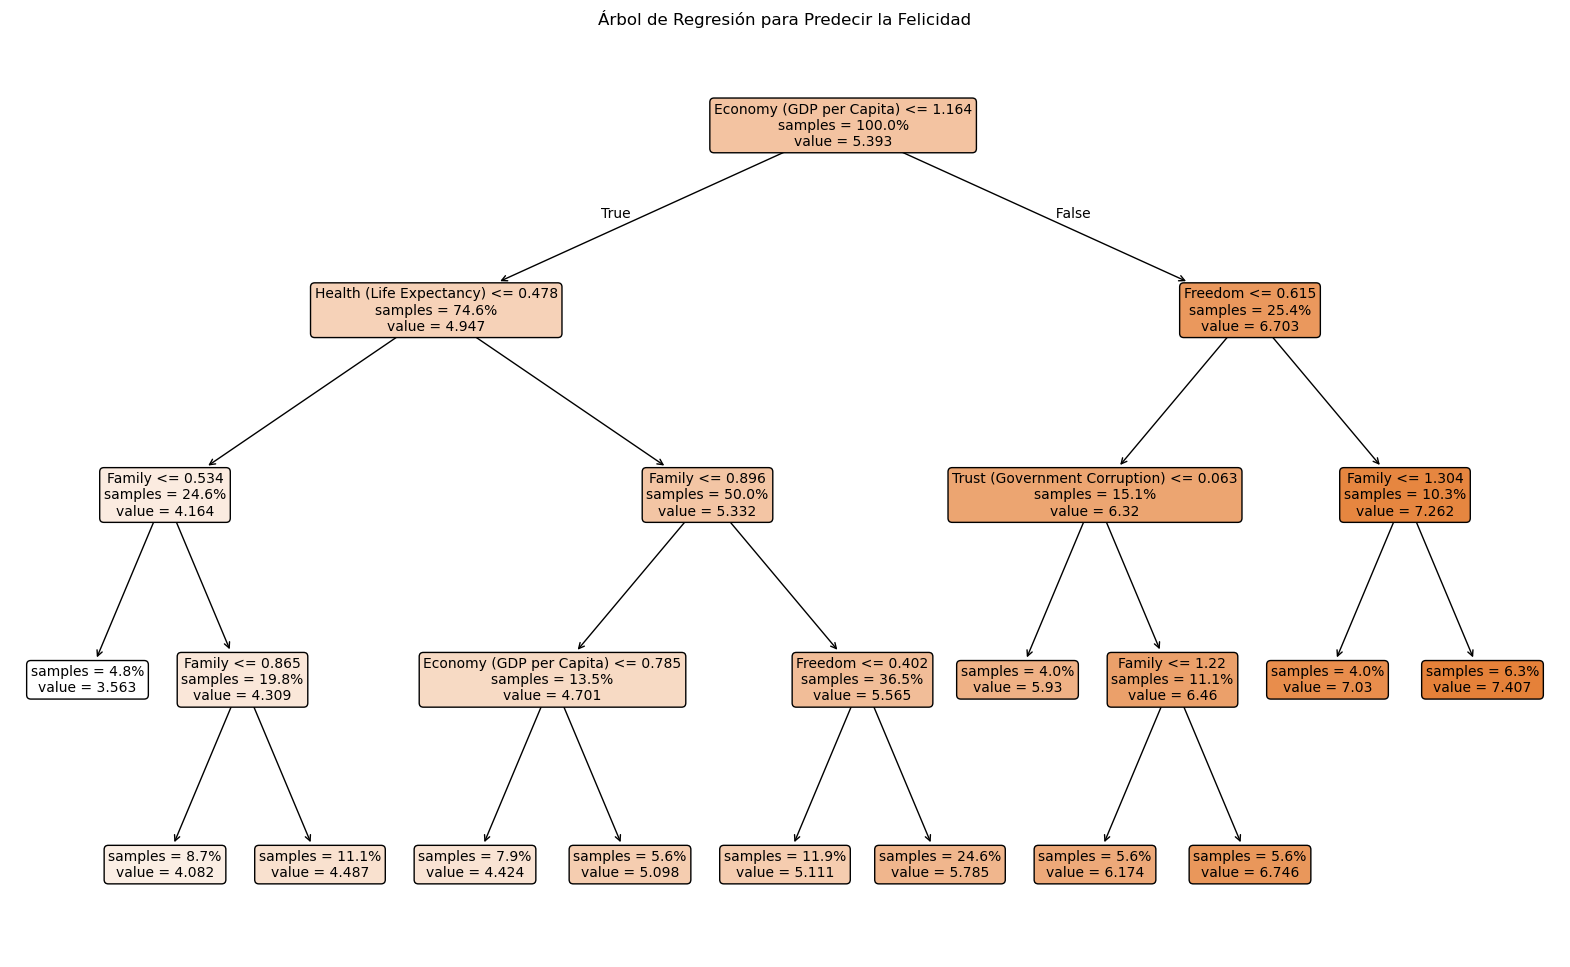

In [ ]:
# Dividimos datos
X = data_clean[selected_features]
y = data_clean[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos y entrenamos el modelo
tree_reg = DecisionTreeRegressor(
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
tree_reg.fit(X_train, y_train)

plt.figure(figsize=(20, 12))
plot_tree(tree_reg,
          feature_names=selected_features,
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True,
          impurity=False)
plt.title("Árbol de Regresión para Predecir la Felicidad")
plt.show()

A continuación, vamos a medir el rendimiento del modelo.

In [ ]:
# Métricas
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        'MAE_train': mean_absolute_error(y_train, y_train_pred),
        'MAE_test': mean_absolute_error(y_test, y_test_pred),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R2_train': r2_score(y_train, y_train_pred),
        'R2_test': r2_score(y_test, y_test_pred),
        'Explained Variance_train': explained_variance_score(y_train, y_train_pred),
        'Explained Variance_test': explained_variance_score(y_test, y_test_pred)
    }

    return pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])

metrics_df = evaluate_model(tree_reg, X_train, X_test, y_train, y_test)
print("\nMétricas de evaluación del modelo:")
print(metrics_df)


Métricas de evaluación del modelo:
                             Value
MAE_train                 0.363138
MAE_test                  0.458711
RMSE_train                0.483073
RMSE_test                 0.544509
R2_train                  0.816515
R2_test                   0.791020
Explained Variance_train  0.816515
Explained Variance_test   0.791857


- MAE (Error Absoluto Medio):

Train: 0.36 / Test: 0.46: Esto implica que en promedio, nuestras predicciones se equivocan por 0.36-0.46 puntos en la escala de felicidad (que va de 2.9 a 7.6)

- RMSE (Raíz del Error Cuadrático Medio):

Train: 0.48 / Test: 0.54: Similar al MAE, pero penaliza más los errores grandes. Sigue siendo un error aceptable.

- R²:

Train: 0.82 / Test: 0.79: El modelo explica 80% de la variabilidad en los datos.

- Varianza Explicada:

Coincide con R², confirmando la consistencia.

Vamos a realizar una prueba de validación cruzada. Esta es una técnica para evaluar modelos de machine learning. Es un examen rotativo donde se dividen los datos en partes iguales (folds), se dividen en train/test, se calcula el RMSE y se rota la prueba hasta que todas las partes hayan sido examinadas. Se calcula un RMSE promedio y con ello podemos interpretar los resultados.

In [ ]:
# Validación cruzada
cv_scores = cross_val_score(tree_reg, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print("\nValidación Cruzada (5 folds):")
print(f"RMSE promedio: {cv_rmse_scores.mean():.4f} ± {cv_rmse_scores.std():.4f}")


Validación Cruzada (5 folds):
RMSE promedio: 0.9540 ± 0.1952


Tenemos que el RMSE promedio es 0.954 vs RMSE de test de 0.544.

La diferencia sugiere que algunas combinaciones de países son más difíciles de predecir que otras

La desviación de ±0.195 indica cuánto varía el error entre folds.

Ahora vamos a ver otros análisis como el gráfico de predicciones vs reales, el gráfico de residuos y la importancia de las variables seleccionadas en el modelo.

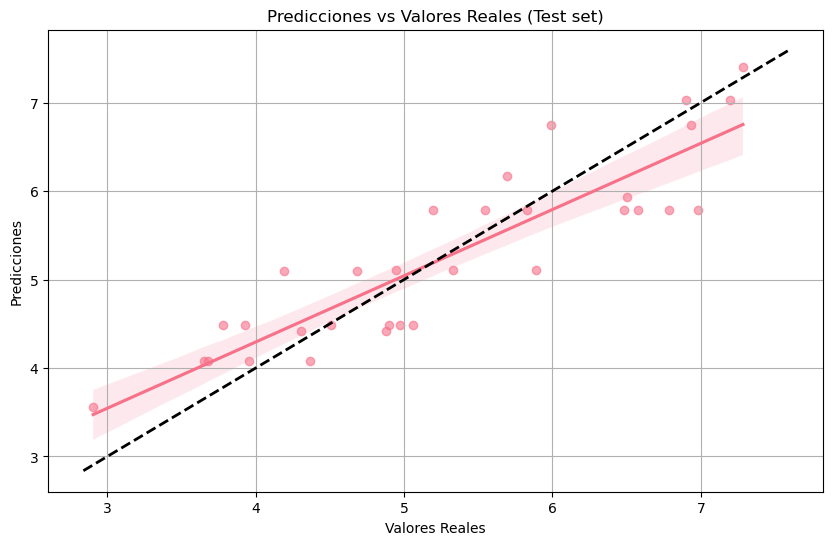

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=tree_reg.predict(X_test), scatter_kws={'alpha':0.6})
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Predicciones vs Valores Reales (Test set)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

En la gráfica anterior, vemos que el modelo sigue la tendencia esperada, aunque con algo de dispersión.

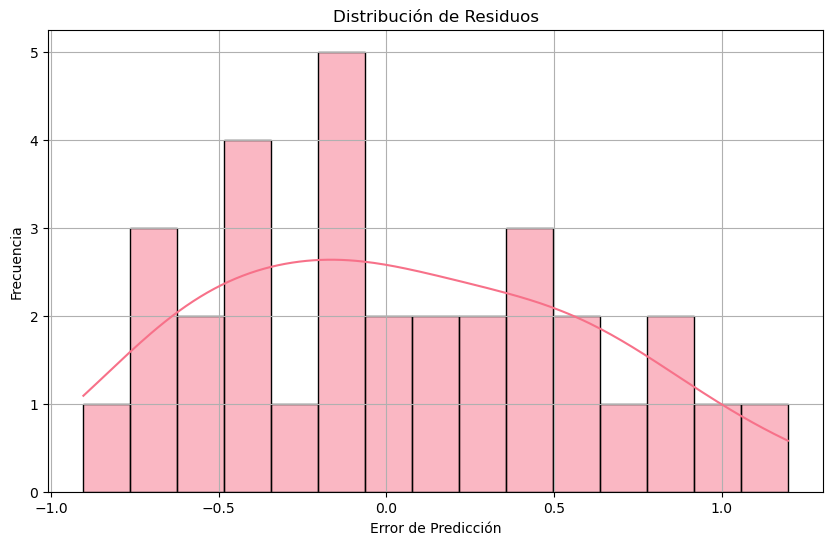

In [ ]:
residuals = y_test - tree_reg.predict(X_test)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=15)
plt.title('Distribución de Residuos')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

En la gráfica anterior, vemos que el modelo tiene errores distribuidos de manera no completamente simétrica, con una ligera tendencia a sobreestimar.

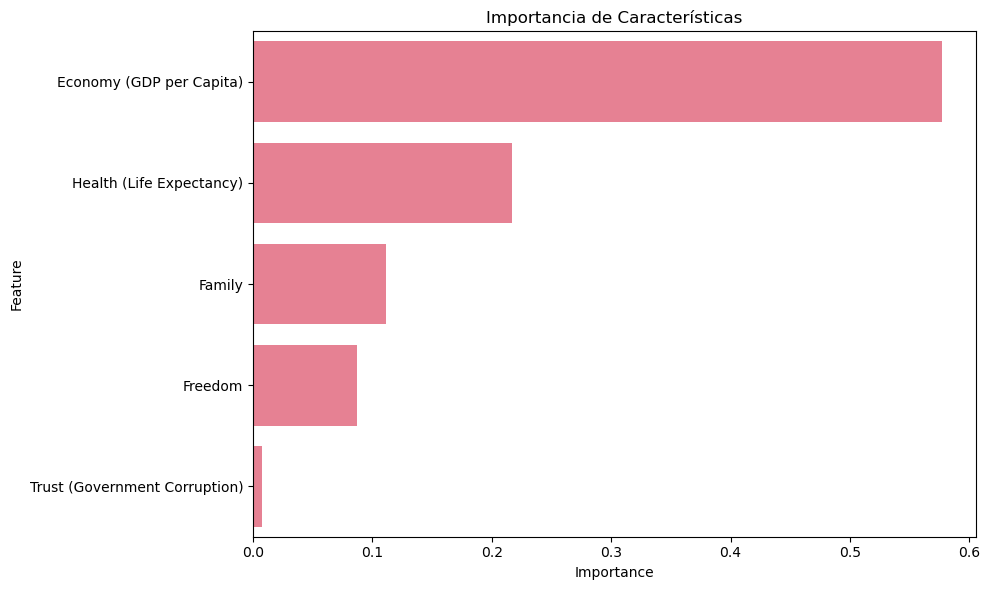

In [ ]:
feature_imp = pd.DataFrame({
    'Feature': selected_features,
    'Importance': tree_reg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title('Importancia de Características')
plt.tight_layout()
plt.show()

Por último, vamos a realizar un análisis de los errores por región. Esto es interesante porque vemos que parece ser un buen modelo, sin embargo, con los análisis anteriores vemos que hay fallas. Con este análisis vamos a analizar cómo varía el desempeño del modelo según la región geográfica, y esto nos podrá ayudar a determinar qué factores deberíamos investigar para explicar los sesgos del modelo.

In [ ]:
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = tree_reg.predict(X_test)
results['Residual'] = results['Actual'] - results['Predicted']
results['Region'] = data.loc[X_test.index, 'Region']

region_error = results.groupby('Region')['Residual'].agg(['mean', 'std', 'count'])
print("\nError promedio por región:")
print(region_error.sort_values('mean', ascending=False))


Error promedio por región:
                                     mean       std  count
Region                                                    
Latin America and Caribbean      0.745877  0.438036      5
Central and Eastern Europe       0.238753  0.513647      4
Southeastern Asia                0.167700  0.402344      2
Western Europe                  -0.039467  0.381049      3
Sub-Saharan Africa              -0.100008  0.479608     11
Australia and New Zealand       -0.123000       NaN      1
Middle East and Northern Africa -0.363451  0.431364      5
Eastern Asia                    -0.758714       NaN      1



- mean (Error promedio):

Valores positivos: El modelo subestima la felicidad en esa región

Valores negativos: El modelo sobreestima la felicidad

Cerca de cero: Predicciones más precisas

- std (Desviación estándar):

Mide cuán consistentes son los errores

Valores altos indican que hay países en la región con errores muy variables

count:

Número de países evaluados en cada región


Como conclusión de este análisis, vemos que el modelo funciona bien para Europa Occidental y África, pero tiene sesgos sistemáticos en otras regiones, como en latinoamérica donde está subestimando la felicidad. De hecho, el que Latinoamérica muestre mayor felicidad de lo que predicen sus indicadores económicos es un fenómeno real conocido como la "Paradoja Latinoamericana de la Felicidad" y este modelo captó dicho fenómeno.